---
title: "Continuous Outcomes"
author: Josie Athens
date: today
highlight-style: nord
format:
  html:
    code-fold: false
    theme: mint
    toc: true
    number-sections: true
    toc-title: Contents
    smooth-scroll: true
    embed-resources: true
execute: 
  cache: true
  warning: false
---

In [5]:
#| output: false
library(tidyverse)
library(rstatix)
library(easystats)
library(ggfortify)
library(pubh)
library(sjlabelled)

jama = ggsci::scale_color_jama()
import::from(latex2exp, TeX)
import::from(epiDisplay, ci)
theme_set(see::theme_lucid(base_size = 10))
options('huxtable.knit_print_df' = FALSE)
options('huxtable.autoformat_number_format' = list(numeric = "%5.2f"))

library("repr")
options(repr.plot.width = 6, repr.plot.height = 4)

# Overview

In this laboratory, we will learn about hypothesis testing, in particular, one-sample $t$-tests, and two-sample $t$-tests for means.

Once you have completed this laboratory, you should feel comfortable:

-   Generating confidence intervals for means.
-   Performing one-sample $t$-tests against a hypothesised mean.
-   Performing two-sample $t$-tests, using either paired or independent samples.
-   Performing non-parametric tests on continuous outcomes

## Summary of New Commands

| **Command**      | **Library** | **Function**                                        |
|------------------|-------------|-----------------------------------------------------|
| **gen_bst_df**   | *pubh*      | Estimates confidence intervals by group             |
| **shapiro_test** | *rstatix*   | Performs the Shapiro-Wilk normality test            |
| **TeX**          | *latex2exp* | Converts *LaTeX* expressions for use in plot labels |
| **var.test**     | *stats*     | Performs variance ratio test                        |
| **wilcox_test**  | *rstatix*   | Performs Wilcoxon-Mann-Whitney test                 |

# Confidence Intervals around the Mean

::: callout-tip
## Example

The data set we will be using for this laboratory is from Bernard, GR, *et al*. (1997) The effects of ibuprofen on the physiology and survival of patients with sepsis, *N Engl J Med* 336(13): 912--918. Here is an abbreviated version of the abstract.

> $\dots$ we conducted a randomized, double-blind, placebo-controlled trial of intravenous ibuprofen$\dots$ in 455 patients who had sepsis, defined as fever, tachycardia, tachypnea, and acute failure of at least one organ system. In the ibuprofen group, but not the placebo group, there were significant declines in [various measures including] temperature$\dots$ However, treatment with ibuprofen did not reduce the incidence or duration of shock or the acute respiratory distress syndrome and did not significantly improve the rate of survival at 30 days (mortality, 37 percent with ibuprofen vs. 40 percent with placebo).
:::

Let's take a look at the head of the data:

In [2]:
data(Bernard)
Bernard |> data_codebook()

ID,Name,Label,Type,Missings,Values,N,Prop,.row_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,id,ID,numeric,0 (0.0%),"[1, 455]",455,,1
,,,,,,,,1
2,treat,Treatment,categorical,0 (0.0%),Placebo,231,50.8%,2
,,,,,Ibuprofen,224,49.2%,2
,,,,,,,,2
3,race,Ethnicity,categorical,0 (0.0%),White,293,64.4%,3
,,,,,African American,130,28.6%,3
,,,,,Other,32,7.0%,3
,,,,,,,,3


We start by saving the label for baseline temperature in a new variable:

In [3]:
btemp = TeX("Baseline Temperature ($^{\\degree}$C)")

::: callout-note
The function `TeX` allows us to include symbols and mathematical expressions in plots and labels using *LaTeX* syntax. *LaTeX* commands are declared between two dollar signs. Special symbols, like Greek letters, use `\`. In `Markup` documents, you only use one `\` (the standard in *LaTeX*), but in `R` functions, you need to use two instead of one, hence `$\\degree$` produces $^{\circ}$. Besides `$\degree$`, the most common symbols are Greek letters, for example, `$\\alpha$` produces $\alpha$ in `R` functions.
:::

::: callout-caution
## Exercise
Construct a histogram of baseline temperatures in $^{\circ}C$ with a normal curve superimposed.
:::

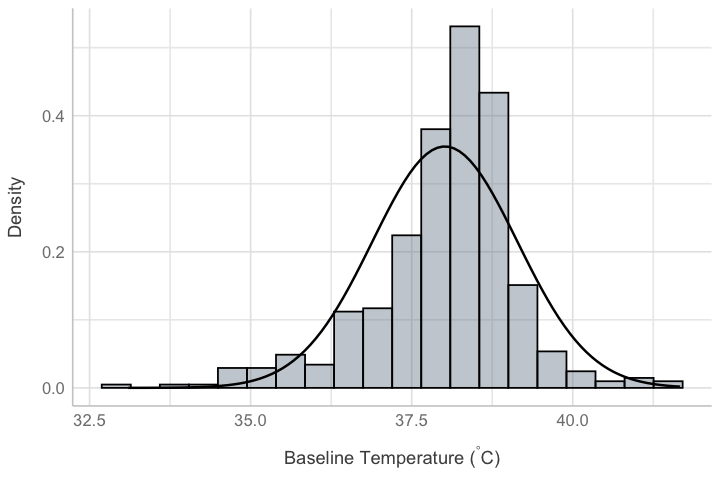

In [4]:
#| label: fig-fig1
#| fig-cap: "Distribution of baseline temperature from the Bernard data set."
#| code-fold: true
Bernard |>
  hist_norm(~ temp0, fill = "slategray", bins = 20, xlab = btemp)

We will now estimate a 95% confidence interval for mean baseline temperature for all patients.

In [6]:
Bernard %$% ci(temp0) |> round(2)

,n,mean,sd,se,lower95ci,upper95ci
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,455,38.01,1.13,0.05,37.91,38.12


## Bootstrap

Recall that the distribution of samples follows a normal distribution. For example, the distribution of means follows a normal distribution. If we obtain, for instance, a thousand samples with replacement and for each one of them we estimate a statistic (e.g., the mean), we will end up with a population of 1,000 statistics. The distribution of the statistics is normal, and it is easy to estimate confidence intervals from them (they correspond to quantiles). This is independent of the original distribution of our original variable of interest. This approach is known as bootstrapping. We usually run the calculation by taking 1,000 or 10,000 samples.

In [7]:
Bernard %$% bst(temp0)

,stat,estimate,%CI,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
,mean,38.01,95,37.92,38.11


::: callout-caution
## Exercise

Estimate the 95% bootstrap CIs for the temperature after 36 hr of treatment (`temp10`).
:::

In [8]:
#| code-fold: true
Bernard %$% bst(temp10)

,stat,estimate,%CI,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
,mean,37.31,95,37.22,37.4


# Tests for Means

## One-sample $t$-tests

Perform the following two-sided one-sample $t$-test, where the normal core temperature is 37$^{\circ}C$. Note that because sepsis was diagnosed in this case by a set of symptoms including fever, you would be very surprised if there were no evidence of a difference between the mean baseline temperature of sepsis patients and the normal body temperature.

If we define $\bar x$ as the mean baseline temperature, our two hypotheses are:

-   $H_0: \bar x = 37^{\circ}C$
-   $H_A: \bar x \neq 37^{\circ}C$

Take a look at the help file of `t.test` to get familiarised with its options. By default, we are using a two-sided test, with a significant $\alpha=0.05$ (95% CI).

In [9]:
Bernard |>
  t_test(temp0 ~ 1, mu = 37, detailed = TRUE)

,estimate,.y.,group1,group2,n,statistic,p,df,conf.low,conf.high,method,alternative
,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
mean of x,38.01492,temp0,1,null model,455,19.23306,9.84e-61,454,37.91122,38.11862,T-test,two.sided


::: callout-important
## Interpretation

We are making a one-sample test, comparing the mean baseline temperature, against the mean reference value of $\mu$ = 37 $^{\circ}C$. Because the test is two-sided, if our mean value is significantly greater or significantly less than $\mu$ = 37 $^{\circ}C$ we reject the null hypothesis. The probability of observing a mean baseline temperature of $\bar x$ = 37 $^{\circ}C$ in our sample is $p$ \< 0.001. The mean baseline temperature in our sample was $\bar x$ = 38.0 $^{\circ}C$ (95% CI: 37.9 $^{\circ}C$, 38.1 $^{\circ}C$).
:::

One of the assumptions of the one-sample $t$-test is that the distribution of the variable is normal. Was that the case?

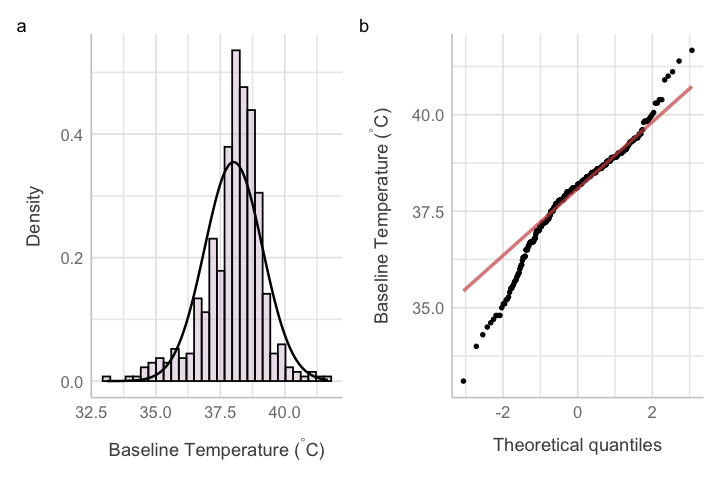

In [10]:
#| label: fig-fig2
#| fig-cap: "Distribution of baseline temperatures for the `Bernard` data set. (a) Histogram with a superimposed normal curve. (b) QQ-plot against the standard normal distribution."
p1 = Bernard |>
  hist_norm(~ temp0, bins = 30, fill = "thistle3") |>
  gf_labs(x = btemp)

p2 = Bernard |>
  qq_plot(~ temp0) |>
  gf_labs(y = btemp)

plots(p1, p2, n_columns = 2, tags = "a")

::: callout-important
## Interpretation

There are deviations from normality in baseline temperature. Lower temperatures are particularly very unlikely to come from a normal distribution.
:::

Our sample is large enough to not be worried about small deviations from normality. In healthy subjects, the temperature would be expected to be centred, and normally distributed. We will look at options when we have concerns about the $t$-test later in this lab.